# Loss VS angle

Is the error bigger for slower speeds for the non-extreme angle values?

This notebook puts the losses to angle range bins and compares the average losses of different angle ranges over the datasets and models with different speeds

## Load data

In [1]:
import pandas as pd
df = pd.read_csv('gt_and_preds.csv.gz', index_col=0)
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 158256 entries, 0 to 158255
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   model speed         158256 non-null  object 
 1   model type          158256 non-null  object 
 2   data speed          158256 non-null  object 
 3   ground_truth_angle  158256 non-null  float64
 4   predicted_angle     158256 non-null  float64
dtypes: float64(2), object(3)
memory usage: 7.2+ MB


## Arrange all data points into 11 bins based on ground truth angle and predicted angle

In [25]:
import numpy as np
df['squared_error'] = np.square(df.predicted_angle - df.ground_truth_angle)
df['absolute_error'] = abs(df.predicted_angle - df.ground_truth_angle)
out, bins = pd.cut(df.ground_truth_angle, bins=11, retbins=True)
out = out.reset_index(drop = True)
df['gt_bin'] = out
bins[0] -=1
bins[-1] += 1
df['pred_bin'] = pd.cut(df.predicted_angle, bins=bins, include_lowest=True).reset_index(drop = True)
sum(df['pred_bin'].isna())


0

In [21]:
grouping_features = ['model speed', 'model type', 'data speed']
df.groupby(grouping_features).mean()


Unnamed: 0  ground_truth_angle  \
model speed model type data speed                                   
fast        3d         fast            9624.5           -0.256872   
                       slow           87183.5           -0.246766   
            linear     fast           48132.5           -0.256416   
                       slow          127793.5           -0.246811   
slow        3d         fast           28874.5           -0.256872   
                       slow          107487.5           -0.246766   
            linear     fast           67398.5           -0.256416   
                       slow          148101.5           -0.246811   

                                   predicted_angle  squared_error  \
model speed model type data speed                                   
fast        3d         fast              -0.239951       0.012006   
                       slow              -0.223632       0.009778   
            linear     fast              -0.254395       0.001159   
                       slow              -0.244458       0.001539   
slow        3d         fast              -0.221902       0.036911   
                       slow              -0.213829       0.011818   
            linear     fast              -0.257349       0.006187   
                       slow              -0.245450       0.001333   

                                   absolute_error  
model speed model type data speed                  
fast        3d         fast              0.081587  
                       slow              0.074300  
            linear     fast              0.023740  
                       slow              0.026628  
slow        3d         fast              0.134753  
                       slow              0.081858  
            linear     fast              0.047309  
                       slow              0.023205

In [27]:
df.groupby(grouping_features).mean()[['squared_error']]

squared_error
model speed model type data speed               
fast        3d         fast             0.012006
                       slow             0.009778
            linear     fast             0.001159
                       slow             0.001539
slow        3d         fast             0.036911
                       slow             0.011818
            linear     fast             0.006187
                       slow             0.001333

In [28]:
df.groupby(grouping_features).mean()[['absolute_error']]

absolute_error
model speed model type data speed                
fast        3d         fast              0.081587
                       slow              0.074300
            linear     fast              0.023740
                       slow              0.026628
slow        3d         fast              0.134753
                       slow              0.081858
            linear     fast              0.047309
                       slow              0.023205

In [29]:
df.groupby(grouping_features).median()[['absolute_error']]

absolute_error
model speed model type data speed                
fast        3d         fast              0.058349
                       slow              0.056170
            linear     fast              0.017137
                       slow              0.016401
slow        3d         fast              0.076404
                       slow              0.060478
            linear     fast              0.022665
                       slow              0.013565

In [30]:
from matplotlib import pyplot as plt

def autolabel(rects, ax=None):
    if ax:
        plotting = ax
    else:
        plotting = plt
    for rect in rects:
        height = rect.get_height()
        plotting.text(rect.get_x() + rect.get_width()/2., 1.01*height, int(height*1000)/1000, ha='center', va='bottom')


## Plot histograms for ground truth and predictions for both speeds for fast 3d model

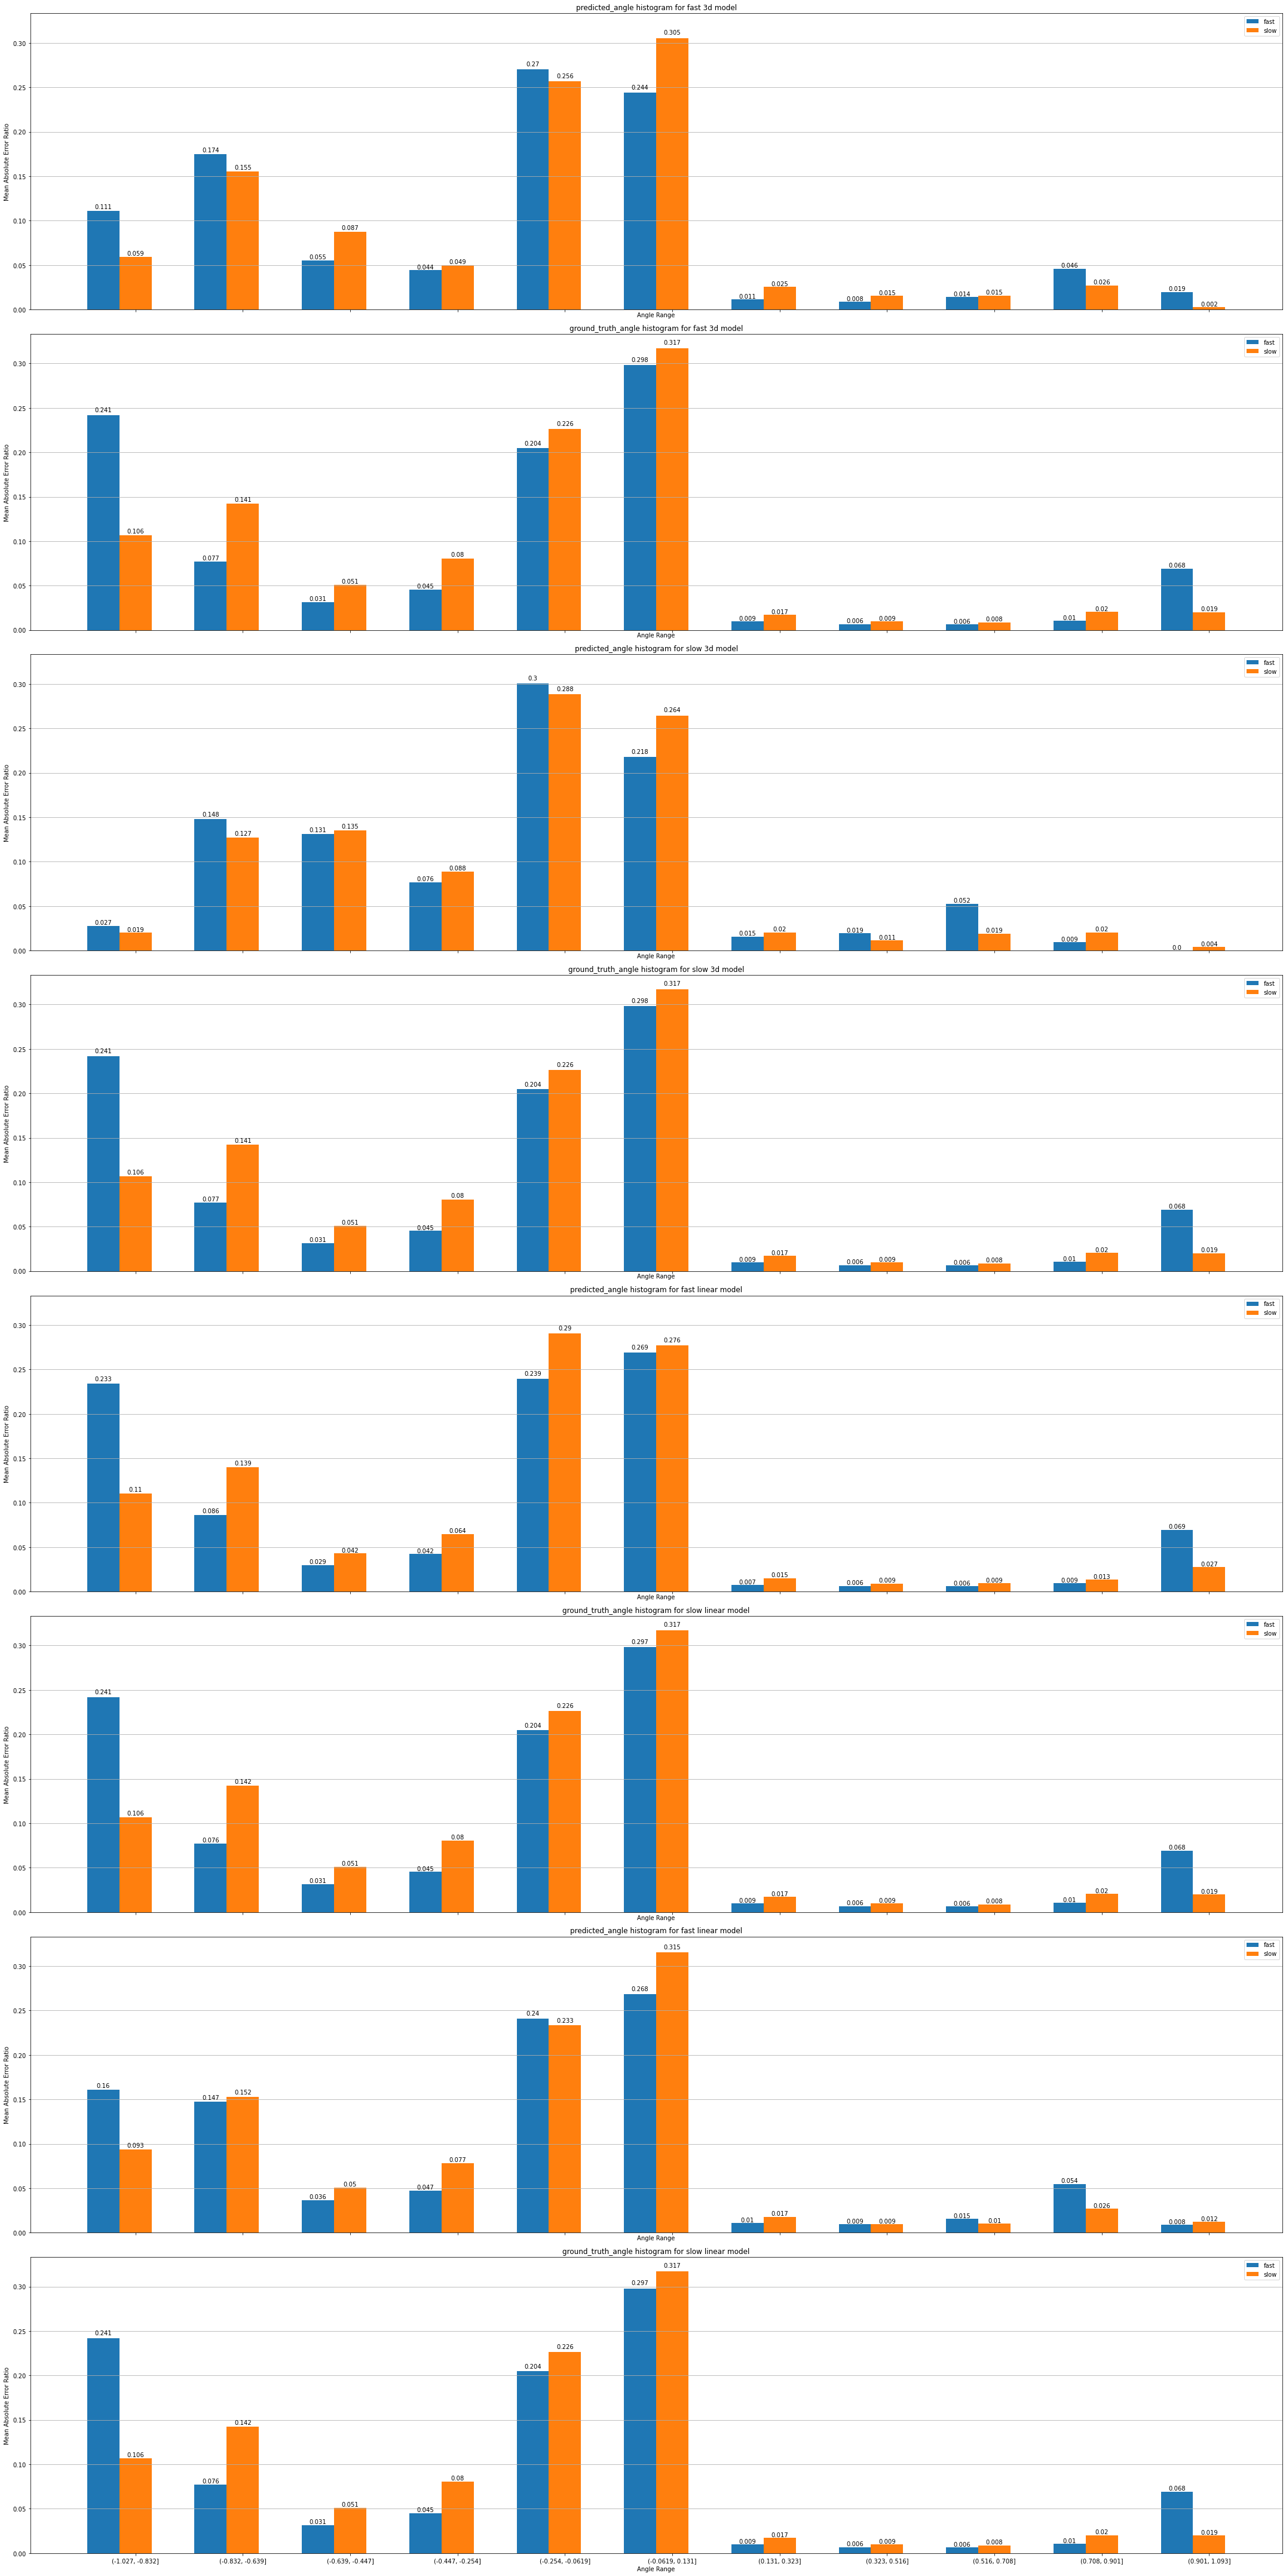

In [45]:
def plot_both_speed_histograms(ax, df: pd.DataFrame, y_column_name: str, x_column_name: str, model_name: str):
    ind = np.arange(df.gt_bin.unique().size)
    width = 0.3

    for i, speed in enumerate(['fast', 'slow']):
        speed_df = df[df['data speed'] == speed]
        grouped = speed_df.groupby(x_column_name)
        total_count = speed_df[y_column_name].count()
        group_count = grouped[y_column_name].count()
        ratios = group_count / total_count
        rects = ax.bar(i*width+ind, ratios, label=speed, width=width)
        autolabel(rects, ax)

    ax.set(title=f'{y_column_name} histogram for {model_name} model',
           ylabel='Mean Absolute Error Ratio',
           xlabel='Angle Range',
           xticks = ind + width,
           xticklabels = ratios.index)

    ax.legend(loc='best')

fig, axs = plt.subplots(nrows=8, ncols=1, figsize=(30, 60), sharex='all', sharey='all')


ax = axs.flat[0]
ax.grid(True, axis='y')
plot_both_speed_histograms(ax, df[(df['model speed'] == 'fast') & (df['model type'] == '3d')], 'predicted_angle', 'pred_bin', 'fast 3d')
ax.legend()

ax = axs.flat[1]
ax.grid(True, axis='y')
plot_both_speed_histograms(ax, df[(df['model speed'] == 'fast') & (df['model type'] == '3d')], 'ground_truth_angle', 'gt_bin', 'fast 3d')
ax.legend()

ax = axs.flat[2]
ax.grid(True, axis='y')
plot_both_speed_histograms(ax, df[(df['model speed'] == 'slow') & (df['model type'] == '3d')], 'predicted_angle', 'pred_bin', 'slow 3d')
ax.legend()

ax = axs.flat[3]
ax.grid(True, axis='y')
plot_both_speed_histograms(ax, df[(df['model speed'] == 'slow') & (df['model type'] == '3d')], 'ground_truth_angle', 'gt_bin', 'slow 3d')
ax.legend()

ax = axs.flat[4]
ax.grid(True, axis='y')
plot_both_speed_histograms(ax, df[(df['model speed'] == 'fast') & (df['model type'] == 'linear')], 'predicted_angle', 'pred_bin', 'fast linear')
ax.legend()

ax = axs.flat[5]
ax.grid(True, axis='y')
plot_both_speed_histograms(ax, df[(df['model speed'] == 'slow') & (df['model type'] == 'linear')], 'ground_truth_angle', 'gt_bin', 'slow linear')
ax.legend()

ax = axs.flat[6]
ax.grid(True, axis='y')
plot_both_speed_histograms(ax, df[(df['model speed'] == 'slow') & (df['model type'] == 'linear')], 'predicted_angle', 'pred_bin', 'fast linear')
ax.legend()

ax = axs.flat[7]
ax.grid(True, axis='y')
plot_both_speed_histograms(ax, df[(df['model speed'] == 'slow') & (df['model type'] == 'linear')], 'ground_truth_angle', 'gt_bin', 'slow linear')
ax.legend()

fig.tight_layout()
plt.show()

## Plot squared error ratio for each bin


TODO: edit this: For example, the sum of 0.9-speed squared error ratios of all 11 bins is 1. Same for 0.85 and 0.8.

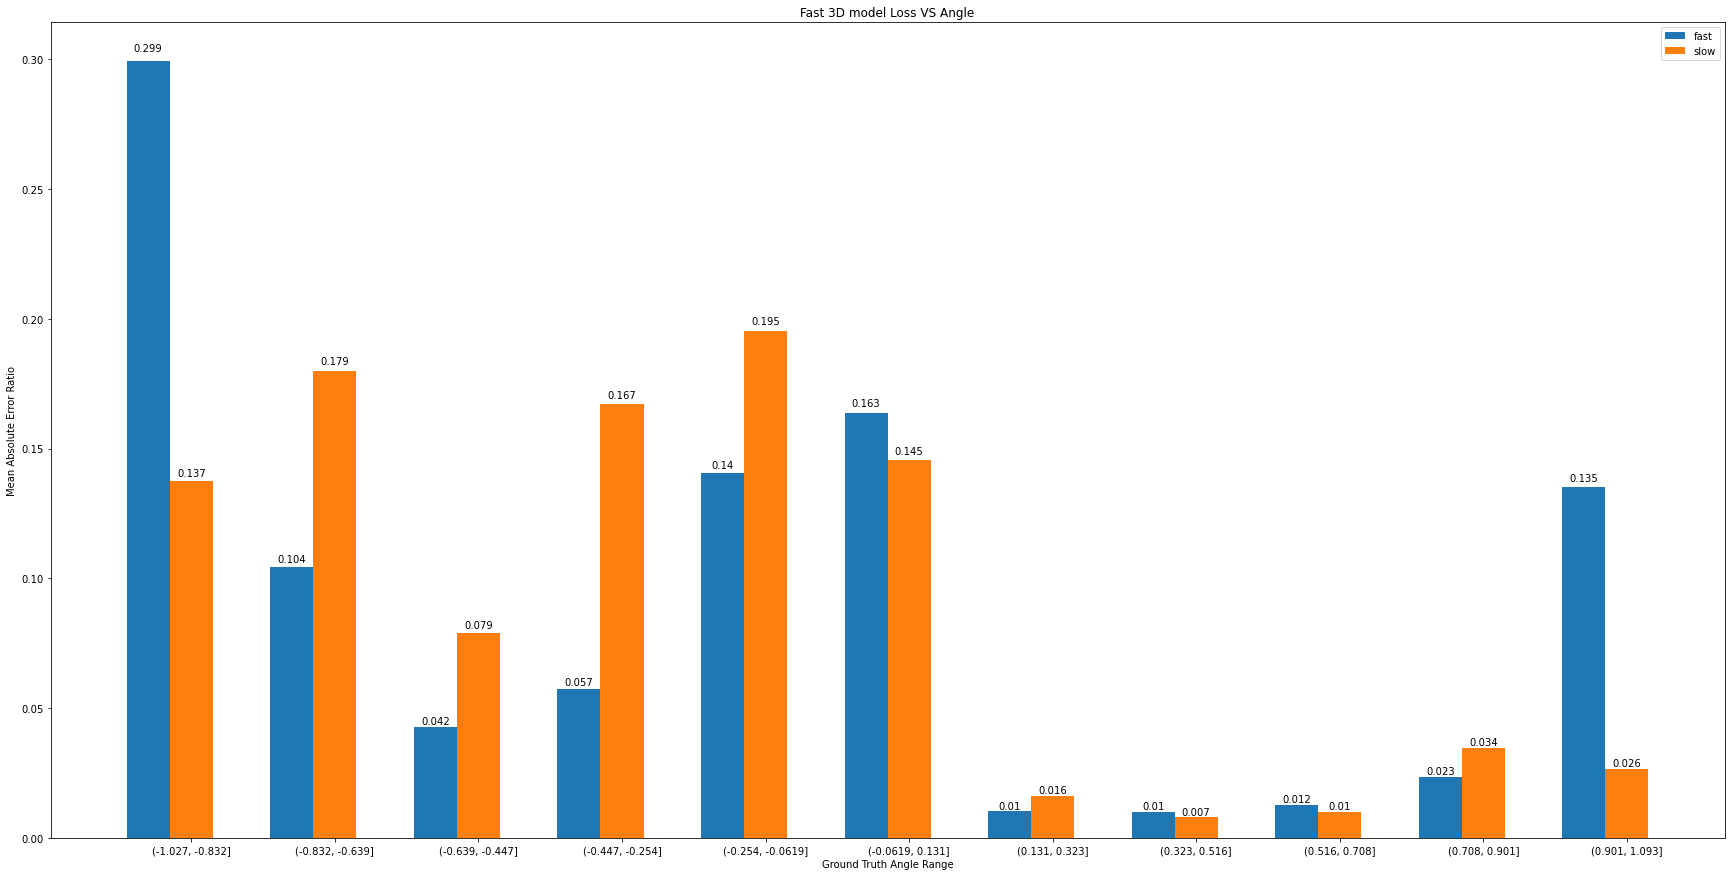

In [52]:
def plot_angle_vs_error_ratios(df: pd.DataFrame, direction: str):
    plt.figure(figsize=(30,15))
    ind = np.arange(df.gt_bin.unique().size)
    width = 0.3

    for i, speed in enumerate(['fast', 'slow']):
        speed_df = df[df['data speed'] == speed]
        total_sum = speed_df.absolute_error.sum()
        grouped = speed_df.groupby('gt_bin')
        group_sum = grouped.absolute_error.sum()
        absolute_error_ratios = group_sum / total_sum
        rects = plt.bar(i*width+ind, absolute_error_ratios, label=speed, width=width)
        autolabel(rects)

    plt.xlabel('Ground Truth Angle Range')
    plt.ylabel('Mean Absolute Error Ratio')
    plt.title(f'{direction} Loss VS Angle')

    plt.xticks(ind + width, absolute_error_ratios.index)
    plt.legend(loc='best')
    plt.show()

plot_angle_vs_error_ratios(df[(df['model speed'] == 'fast') & (df['model type'] == '3d')], 'Fast 3D model')


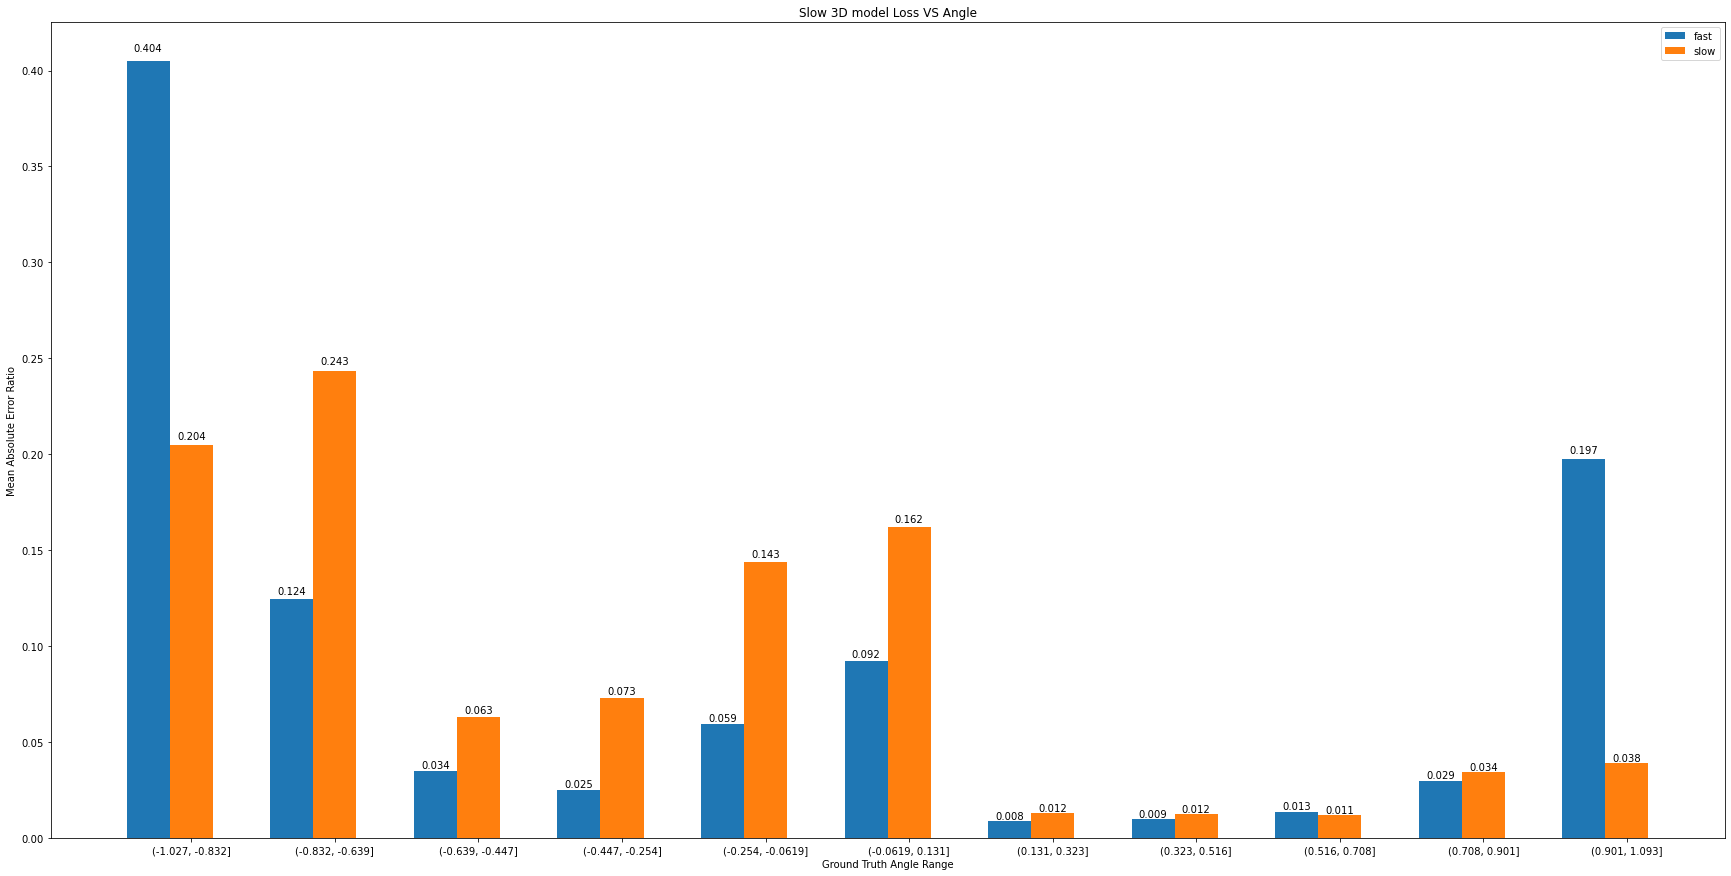

In [53]:
plot_angle_vs_error_ratios(df[(df['model speed'] == 'slow') & (df['model type'] == '3d')], 'Slow 3D model')


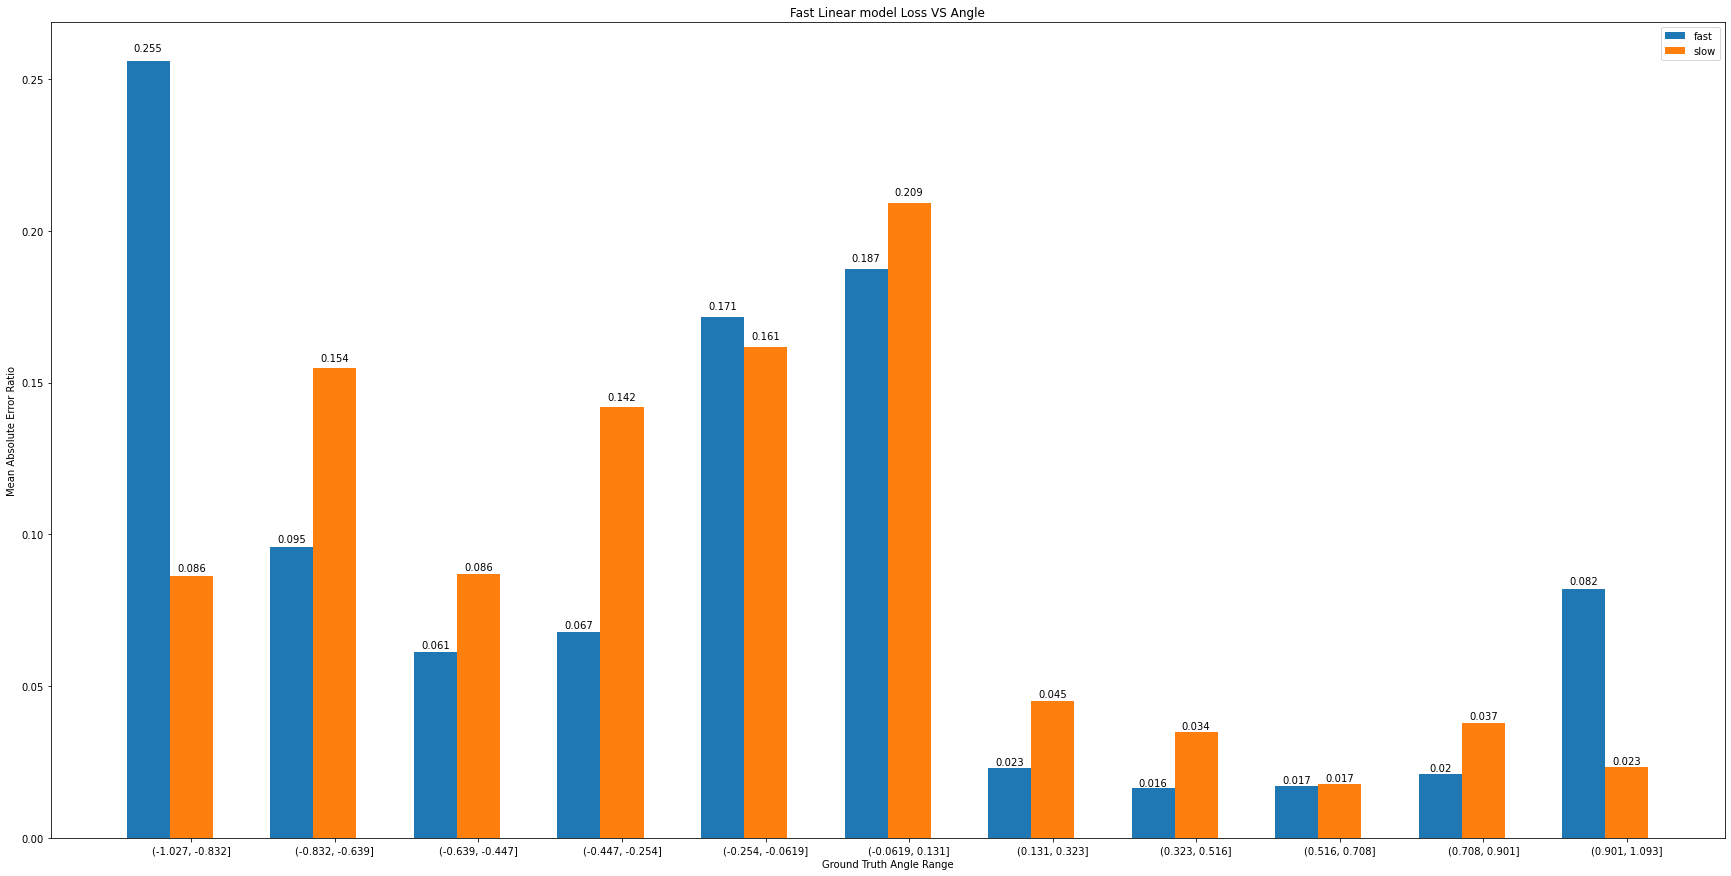

In [54]:
plot_angle_vs_error_ratios(df[(df['model speed'] == 'fast') & (df['model type'] == 'linear')], 'Fast Linear model')


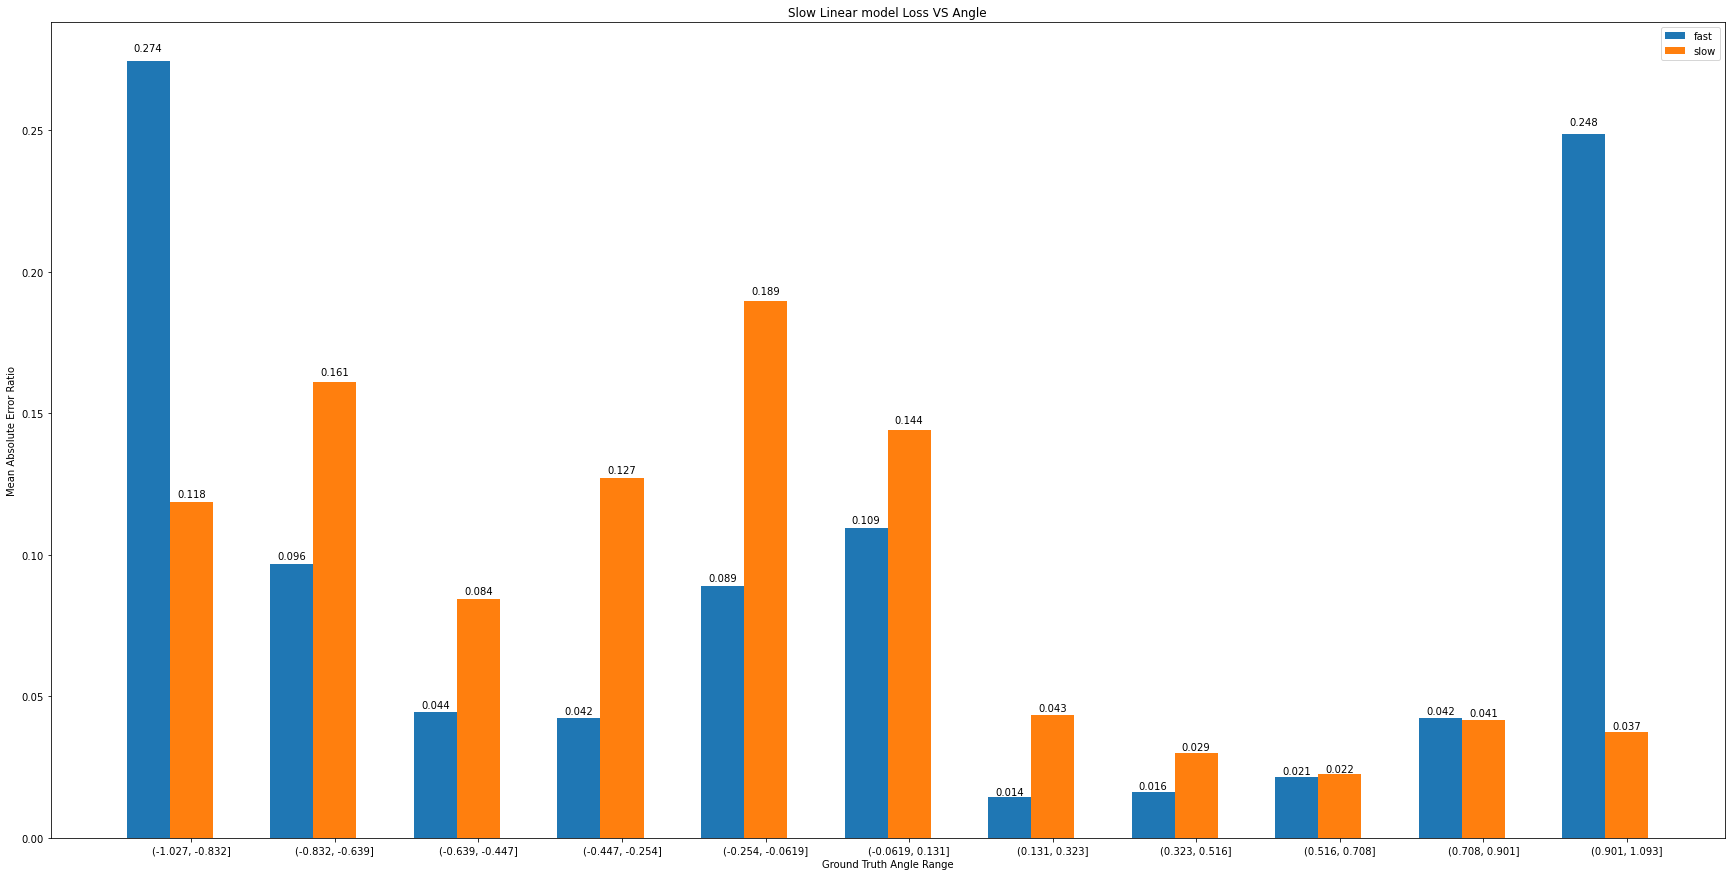

In [55]:
plot_angle_vs_error_ratios(df[(df['model speed'] == 'slow') & (df['model type'] == 'linear')], 'Slow Linear model')


#### Conclusion
For slower speeds, the error is bigger for smaller angles, not far-right (+1) or far-left (-1).
The error is bigger for fast speed data for the maximum angle values, both, far-right and far-left.